# 3. word2vec

## 3.1 추론 기반 기법과 신경망
단어를 벡터로 표현하는 방법중 가장 큰 두가지 방법은 '통계 기반 기법'과 '추론 기반 기법'이다.  
통계 기반 기법은 학습 데이터를 한번에 처리하는 반면, 추론 기반 기법은 학습데이터를 작게 나눠 학습하기 때문에 큰 작업량도 처리할 수 있고, GPU의 힘을 이용한 병렬 계산도 가능해져 학습 속도도 높일 수 있다.

### 3.1.1 통계 기반 기법의 문제점

통계 기반 기법에서는 단어의 Co-occurrence Matrix를 만들고, 그 행렬에 SDV를 적용하여 밀집벡터를 구했지만 이러한 방식은 대규모 말뭉치를 다룰 때 문제가 된다.  

통계 기반 기법은 말뭉치 전체의 통계를 이용해 단 1회의 처리만에 단어의 분산표현을 얻지만 신경망을 이용한 추론 기법에서는 미니배치를 이용해 학습한다.  
신경망은 미니배치로 학습하기 때문에 대규모 말뭉치에서도 학습시킬 수 있다.  


### 3.1.2 추론 기반 기법 개요

추론 기법에서의 추론이란 주변 단어(맥락, context)가 주어졌을 때 "?"에 어떤 단어가 들어가는지 추측하는 것을 말한다.

![](./images/inference.png)

이러한 추론 문제를 방복해서 풀면서 단어의 출현 패턴을 학습한다. 모델은 맥락(context) 정보를 입력받아 각 단어의 출현 확률을 출력한다. '모델 관점'에서 보면 다음과 같다.

![](./images/inference02.png)  

추론 기반 기법도 통계 기반 기법처럼 분포 가설에 기초한다.  
분포 가설이란 '단어의 의미는 주변 단어에 의해 형성된다' 라는 가설로, 추론 기반 기법에서는 이를 앞에서와 같은 추측 문제로 귀결 시켰다.  
'단어의 동시발생 가능성'을 얼마나 잘 모델링 하는가가 중요한 연구 주제이다.  

### 3.1.3 신경망에서의 단어 처리

신경망의 입력층에서의 뉴런 수를 **고정**하기 위해 단어를 일정 길이를 갖는 **고정 길이 벡터**로 변환 해준다. 이때 사용하는 대표적인 방법이 **원핫** 벡터(one-hot vector)다.

| 단어(텍스트) | 단어 ID | one-hot vector        |
| ------------ | ------- | --------------------- |
| you          | 0       | [1, 0, 0, 0, 0, 0, 0] |
| goodbye      | 2       | [0, 0, 1, 0, 0, 0, 0] |


![](./images/one-hot.png) 

위와 같이 원-핫 벡터로 나타낸 단어 벡터를 신경망의 입력으로 주입하고 완전연결계층(FC layer)를 통해 원-핫 벡터로 표현된 단어를 밀집 벡터로 변환해줄 수 있다.

![](./images/nn.png)

편향을 이용하지 않는 완견연결계층은 '행렬 곱'계산에 해당된다.  
딥러닝 프레임워크의 경우 일반적으로 완전연결계층을 생성할 때 편향을 이용할지 선택할 수 있다.  

In [4]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])  # 입력 (one-hot)
W = np.random.randn(7, 3)  # 가중치 (랜덤한 값), Word vector
h = np.matmul(c, W)  # 은닉층 노드
print(h)

[[ 1.3947958   1.39136269 -1.11320273]]


위의 코드에서 `c`는 원-핫 표현이며 단어 ID에 대응하는 원소만 1이고 그 외에는 0인 벡터다. 따라서, `c`와 `W`의 행렬곱은 가중치(`W`)의 행벡터 하나를 **뽑아낸** 것과 같다.

![](./images/matmul.png)

In [5]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-0.75186164 -0.65461666 -0.73338532]]


## 3.2 단순한 Word2Vec

### 3.2.1 CBOW 모델의 추론 처리

**CBOW**(Continuous Bag-Of-Words) 모델은 맥락(context, 주변 단어)로부터 타깃(target, 중심 단어)을 추측하는 신경망이다.  
CBOW는 word2vec에서 사용되는 신경망 중 하나이다.  

![](./images/cbow.png)

- 모델의 입력은 맥락(context) 즉, 주변 단어다.

- 은닉층의 뉴런은 입력층의 완전연결계층에 의해 변환된 값이 되는데, CBOW에서는 `wiindow_size(맥락단어수) * 2`($C$) 개수 만큼 입력이 되므로 전체의 **평균**(average)을 해준다.  


$$
\mathbf{h} = \frac{1}{C} (h_1 + \cdots h_c)
$$


- 출력층의 뉴런은 해당 단어의 개수(`vocab_size`)와 같고, 뉴런 하나하나가 각 단어에 대응한다. 출력층 뉴런은 각 단어의 **'점수'**(score, softmax를 지나기전 상태)를 뜻하며, 값이 높을 수록 대응 단어의 출현 확률도 높아진다.

- 위의 그림에서 $\mathbf{W}_{\text{in}}$의 각 행(row)과 $\mathbf{W}_{\text{out}}$의 각 열(column)이 바로 단어의 분산 표현이 된다. $\mathbf{W}_{\text{in}}$와 $\mathbf{W}_{\text{out}}$ 중 어느것을 써도 상관 없지만 보통 $\mathbf{W}_{\text{in}}$을 사용하는 듯 하다.

In [12]:
# CBOW모델의 추론 처리 구현
# chap03/cbow_predict.py
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c_list = [np.array([[1, 0, 0, 0, 0, 0, 0]]),
          np.array([[0, 0, 1, 0, 0, 0, 0]])]

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c_list[0])
h1 = in_layer1.forward(c_list[1])
h = (h0 + h1)/len(c_list)  # average
s = out_layer.forward(h)  # score

print(s)

[[ 0.61953518  0.03144435 -0.74488417 -0.16413681 -0.95271192 -0.14672957
   0.23056254]]


### 3.2.2 CBOW 모델의 학습

CBOW 모델의 학습에서는 올바른 예측을 할 수 있도록 가중치를 조정한다. 그 결과 가중치 $\mathbf{W}_{\text{in}}$와 $\mathbf{W}_{\text{out}}$에 각 단어의 벡터가 학습된다.

Word2Vec 모델은 단어 출현 패턴을 학습할 때 사용한 말뭉치(corpus)로부터 학습한다. 그렇기 때문에 말뭉치가 다르면 학습 후 얻게 되는 단어의 분산 표현도 달라진다.

![](./images/cbow02.png)
다루고 있는 모델은 다중 클래스 분류를 수행하는 신경망 이다.  
이 신경망을 학습시키기 위해서는 소프트맥스와 교차 엔트로피 오차를 사용해야 한다.

### 3.2.3 Word2Vec의 가중치와 분산 표현

Word2Vec 모델에서는 $\mathbf{W}_{\text{in}}$의 각 행(row)과 $\mathbf{W}_{\text{out}}$의 각 열(column)이 바로 단어의 분산 표현이 된다. 

최종적으로 이용하는 단어의 분산 표현은 다음과 같이 세 가지 선택 사안이 있다.

- 입력 측의 가중치($\mathbf{W}_{\text{in}}$)만 이용한다.

- 출력 측의 가중치($\mathbf{W}_{\text{out}}$)만 이용한다.

- 양쪽 가중치를 모두 이용한다. ($\mathbf{W}_{\text{in}}$와 $\mathbf{W}_{\text{out}}$의 합 등)


Word2Vec에서 특히 skip-gram 모델에서는 '입력 측의 가중치($\mathbf{W}_{\text{in}}$)만 이용한다'가 가장 대중적인 선택이다. 

![](./images/word_vec.png)

## 3.3 학습 데이터 준비

### 3.3.1 맥락과 타깃

Word2Vec, 특히 CBOW에서 이용하는 신경망의 입력은 맥락(context, 주변단어)이고, 정답 레이블은 맥락에 둘러싸인 중앙(center) 단어이다. 신경망에 '맥락'을 입력했을 때 '타깃'이 출현할 확률을 높이는 것이다. CBOW 모델에서 입력 데이터인 맥락은 여러 개(`window_size * 2`)가 될 수 있지만 타깃은 오직 하나 뿐이다.

![](./images/train_set.png)

In [14]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [15]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


![](./images/train_set2.png)

In [16]:
# common/util.py
def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성
    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: (맥락, 타겟)의 np.array
    '''
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        # wiondow_size만큼 타겟 단어 좌우 context 가져오기
        for t in range(-window_size, window_size+1):
            if t != 0:
                cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [17]:
import sys
sys.path.append('..')
from common.util import create_contexts_target

contexts, target = create_contexts_target(corpus, window_size=1)

In [18]:
print(contexts)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [19]:
print(target)

[1 2 3 4 1 5]


### 3.3.2 원핫 표현으로 변환

![](./images/one-hot2.png)

In [21]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환
    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
            
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
                
    return one_hot

In [22]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodby and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [23]:
print(target)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


In [24]:
print(contexts)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


## 3.4 CBOW 모델 구현

In [25]:
# chap03/simple_cbow.py
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f') #astype('f')는 32비트 부동 소수점으로 고정한다는 뜻을 의미한다.
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 레이어 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layers.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out.T
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### 3.4.1 학습 코드 구현

In [26]:
# chap03/train.py
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
# cbow 학습 데이터셋 생성
contexts, target = create_contexts_target(corpus, window_size)
# Input에 맞는 one-hot 표현 변환
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# 모델 초기화
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [27]:
# 학습
trainer.fit(contexts, target, max_epoch, batch_size)

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

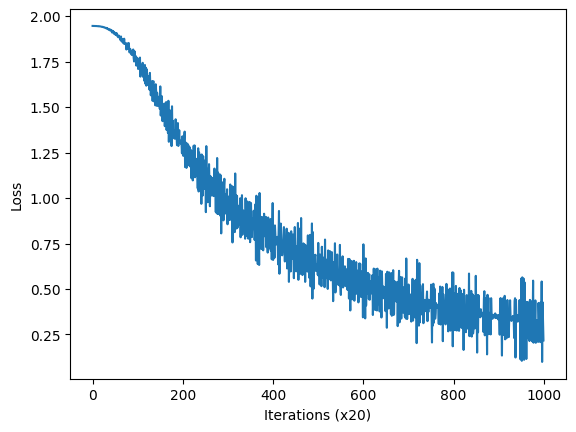

In [28]:
trainer.plot()

In [29]:
# Word Embedding 살펴보기
word_vecs1 = model.word_vecs1
for word_id, word in id_to_word.items():
    print(word, word_vecs1[word_id])

you [ 1.7265909 -0.9531269 -1.0821958  1.0717155  1.0669822]
say [ 1.010411    0.46634716 -1.1891412  -1.2936112  -1.2958506 ]
goodbye [-0.897905  -0.8574934 -0.8015003  1.0318866  1.0120887]
and [ 0.6705304  1.8880999 -1.1752385 -0.7746369 -0.8340749]
i [-0.8973213 -0.855496  -0.8113557  1.0481681  0.9874677]
hello [ 1.738346   -0.94905084 -1.0560435   1.068462    1.0736188 ]
. [ 1.1000371  -1.8086264  -0.72412497 -1.3109952  -1.3060162 ]


In [30]:
# Word Embedding 살펴보기
word_vecs2 = model.word_vecs2
for word_id, word in id_to_word.items():
    print(word, word_vecs2[word_id])

you [-1.0767964   0.6263043   1.341742   -0.14922059 -0.12136059]
say [ 1.5654794  -0.90332776 -0.5819727   1.0328897   1.0663813 ]
goodbye [ 0.36761948  1.2326895  -0.13130262 -0.66682464 -0.68916255]
and [-2.0263412  -0.61406827 -0.2250444   0.72578496  0.7184439 ]
i [ 0.36339185  1.2240313  -0.13725476 -0.68259966 -0.67863935]
hello [ 0.6731208  -1.485903   -0.09038873 -1.0313523  -1.0009006 ]
. [-1.0763859   0.6295819   1.3454856  -0.14305721 -0.12513559]


### t-SNE를 이용한 2차원 공간상의 매핑

                 x          y
you      42.953098 -30.731497
say     -31.997334 -64.764297
goodbye -98.611702 -16.600958
and     -90.647415  65.221031
i       -15.621379  98.675560
hello   -23.853132  17.006971
.        51.097309  50.940926


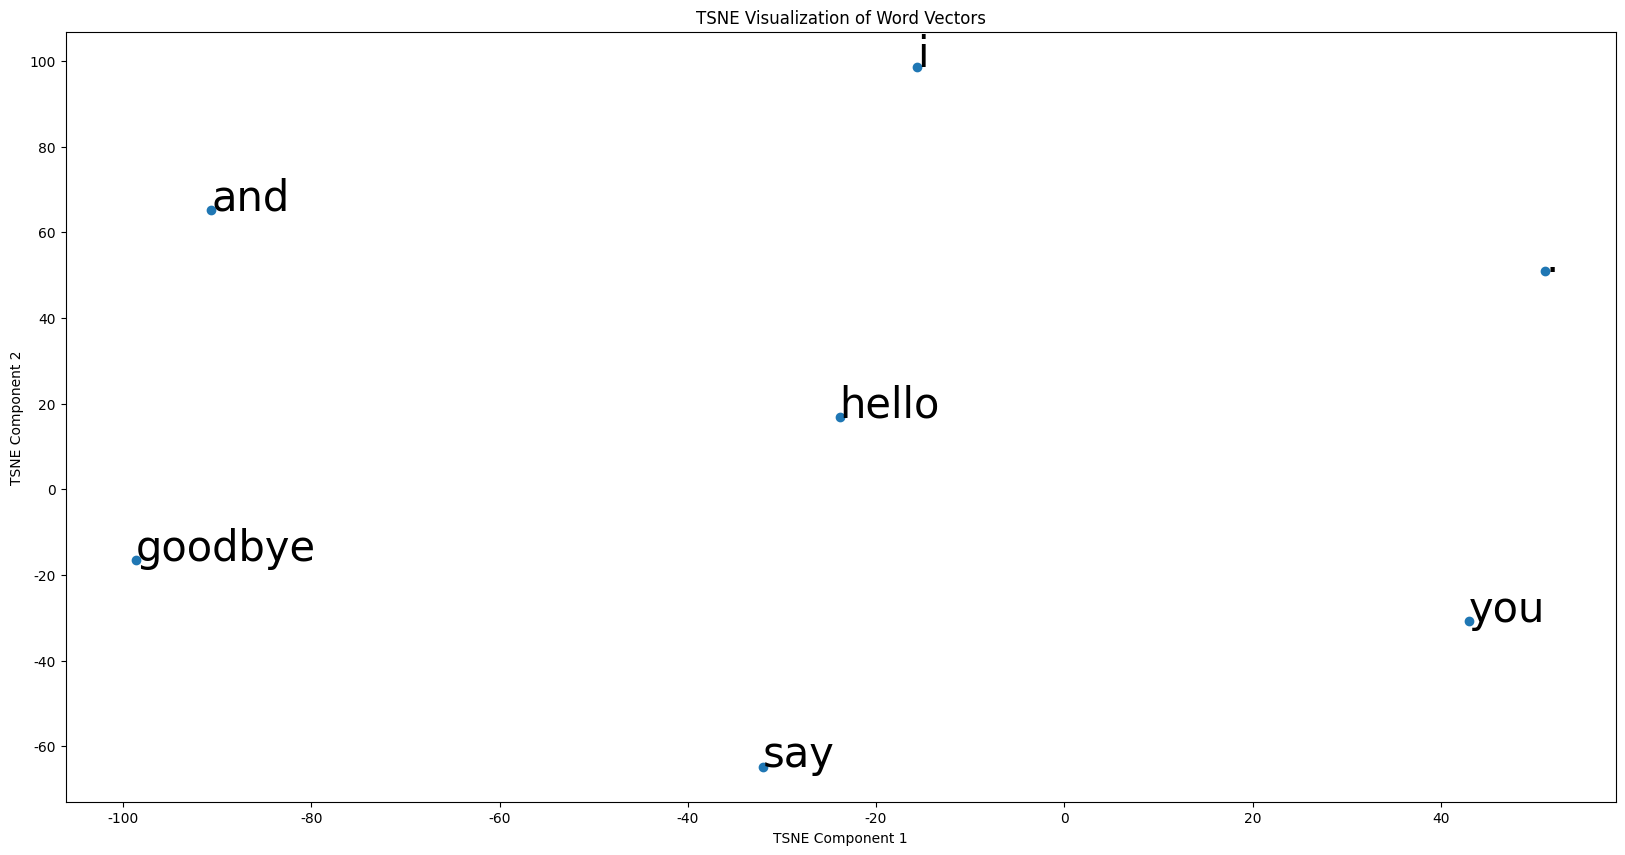

In [47]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# 데이터 샘플 수 확인
n_samples = word_vecs2.shape[0]

# perplexity를 n_samples보다 작게 설정
perplexity_value = min(30, n_samples - 1)

# TSNE 객체 생성 시 perplexity 설정
tsne = TSNE(n_components=2, perplexity=perplexity_value)

# 100개의 단어에 대해서만 시각화 (만약 100개 초과 시 100개만 사용)
num_words = min(100, n_samples)
X_tsne = tsne.fit_transform(word_vecs2[:num_words])

# TSNE 결과를 데이터프레임으로 변환
vocab = list(id_to_word.values())
df_tsne = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
print(df_tsne)
# 시각화
fig = plt.figure()
fig.set_size_inches(20, 10)
ax = fig.add_subplot(1, 1, 1)

# 점들을 시각화
ax.scatter(df_tsne['x'], df_tsne['y'])

# 각 단어에 라벨을 달아줌
for word, pos in df_tsne.iterrows():
    ax.annotate(word, pos, fontsize=30)

plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('TSNE Visualization of Word Vectors')
plt.show()


## 3.5 Word2Vec 보충

### 3.5.1 CBOW 모델과 확률

- $P(A)$ : A가 발생할 확률


- $P(A|B)$ : **사후확률**, **사건**이 일어난 **후의 확률**을 의미
    - 'B가 주어졌을 때 A가 일어날 확률'
    
    
CBOW 모델은 맥락(contexts)을 주면 타깃 단어가 출현할 확률을 출력하는 것이다. 

![](./images/cbow04.png)

위의 그림처럼, 맥락인 $w_{t-1}$과 $w_{t+1}$이 주어졌을 때 타깃이 $w_t$가 될 확률을 수식으로 나타내면 다음과 같다.


$$
P(w_t | w_{t-1}, w_{t+1})
$$

- $w_{t-1}$과 $w_{t+1}$이 주어졌을 때 $w_t$가 일어날 확률  

이 확률을 최대화해야 한다. 하지만 신경망에서의 Cost(Loss) Function는 최소화 문제로 바꿔야하기 때문에, **Negative log likelihood**를 통해 다음과 같이 바꿔준다.  

$$
\max{P(w_t | w_{t-1}, w_t+1)} \rightarrow L = -\log{P(w_t | w_{t-1}, w_t+1)}
$$


### 3.5.2 skip-gram 모델

skip-gram 모델의 입력층은 하나이며, 출력층은 맥락(contexts)의 수만큼 존재한다. 따라서, 각 출력층에서는 개별적으로 손실을 구하고, 이 개별 손실들을 모두 더한 값을 최종 손실로 사용한다.

![](./images/skip-gram02.png)

skip-gram은 다음 식을 모델링한다.


$$
P(w_{t-1}, w_{t+1} | w_t)
$$

skip-gram모델에서는 맥락의 단어들 사이에 관련성이 없다고 가정하는 **'조건부 독립'**에 의해 다음과 같이 분해된다.


$$
P(w_{t-1}, w_{t+1} | w_t) = P(w_{t-1}|w_t)P(w_{t+1}|w_t)
$$

Negative log likelihood를 적용하면 다음과 같이 손실함수를 구할 수 있다.

$$
\begin{align*}
L &= - \log{P(w_{t-1}, w_{t+1} | w_t)} \\ 
&= -\log{P(w_{t-1}, w_{t+1} | w_t)} \\
&= - \left[ \log{P(w_{t-1}|w_t)} + \log{P(w_{t+1}|w_t}) \right]
\end{align*}
$$

이를 말중치 전체로 확장하면 skip-gram 모델의 손실함수는 다음과 같다.

$$
L = - \frac{1}{T} \sum_{t=1}^{T}{ \left[ \log{P(w_{t-1}|w_t)} + \log{P(w_{t+1}|w_t}) \right]}
$$

![](./images/skip-gram.png)

#### CBOW vs Skip-gram

성능면에서는 skip-gram이 CBOW보다 많이 사용된다. 그 이유는 단어 분산 표현의 정밀도 면에서 skip-gram 모델의 결과가 더 좋기 때문이다. 

학습 속도 면에서는 CBOW모델이 더 빠르다. skip-gram모들은 손실을 맥락(contexts)의 수만큼 구해야하므로 그 만큼 계산비용이 커진다.  

In [50]:
# chap03/simple_skip_gram.py
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 레이어 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out.T
        
    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss
    
    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

### 3.5.3. 통계 기반 vs. 추론 기반
새로운 단어가 추가될 때 통계 기반 학습에서는 처움부터 모든 계산을 수행해야 하지만 추론 기반 기법에서는 일부만 수정해서 다시 학습하면 된다.  

실제 단어의 유사성을 정량 평가해본 결과, 의외로 추론 기반과 통계 기반이 우열을 가릴 수 없을 정도로 비슷한 성능을 가진다고 볼 수 있었다.  